# Machine Learning Homework1

---

# Multi-UAV conflict risk analysis :
This is the report for the first homework of the Machine Learning course of 2022 at  Sapienza University. The goal of the homework is to make predictions and risk analysis over a Data-set containing information about 5 different UAV., a more accurate description of the dataset and the assigment is avaliable in the homework report.

The assigment of the homework consists into solving two distinct tasks:

1.   The first is a classification problem: train a ml model to estimate the total number conflicts between UAVs given the provided features;

2.   The second is a regression problem: train a ml model predict the minimum Closest Point of Approach (CPA) among all the possible pairs of UAVs;

The following code shows the resolution process for this problems and outline the experiments made on the data to overcome the limitation of the Data-set itself.
In conclusion all the consideration about this experiments can also be found in the homework report.

# Global operations

---

## Import libraries 

In [14]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dataset splitting
from sklearn.model_selection import train_test_split

# dataset preprocessing (nomalization, oversampling and balancing )
from sklearn.preprocessing import StandardScaler            # for scaler normalizarion
from sklearn.preprocessing import MinMaxScaler              # for min-max normalizarion
from imblearn.over_sampling import RandomOverSampler        # for oversampling
from imblearn.under_sampling import RandomUnderSampler      # for undersampling
from imblearn.over_sampling import SMOTE                    # for balancing
from imblearn.over_sampling import ADASYN                   # for balancing

# models for classification
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# classification output evaluation metrics 
from sklearn.model_selection import ShuffleSplit            # to perform K-fold cross validation
from sklearn.model_selection import cross_val_score         # to perform K-fold cross validation
from sklearn import metrics
#from sklearn.metrics import classification_report          # all this imports belong to scikit learn
#from sklearn.metrics import accuracy_score                 # but the single import was giving problem
#from sklearn.metrics import confusion_matrix               # so I've imported the whole library
#from sklearn.metrics import ConfusionMatrixDisplay         #

# models for regression 
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# regression output evaluation metrics 
#from sklearn import metrics
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score

# grid search 
from sklearn.model_selection import GridSearchCV

## Mount drive and root directory set up

In [15]:
from google.colab import drive
drive.mount('/content/drive')
root_path = './drive/MyDrive/AI_Robotics/ML/homework1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read Data-set with panda:
This instruction is used to load the Data-set, it is in a separate code cell in case one wants to test just one of the two section.\
The given Data-set is in a '.tsv' format so the arg step='\t' was added to specify the tab as a separator. 

In [16]:
# Read data in csv format via panda
dataset = pd.read_csv(root_path+"/train_set.tsv", 
                      sep='\t', header=0)

## Normalization function
This function can perform various kinds of normalization over the Data-set.

In [17]:
def data_normalization(data, normalization_method='Min_Max', normalization_type=0, output=False):
    # normalization cases:

    if (output) : 
        # nomalizing the output (only for regression)
        data = data.values.reshape(-1, 1)                     # returns a numpy single colum matrix
        min_max_scaler = MinMaxScaler()
        data_scaled = min_max_scaler.fit_transform(data)
        #data_scaled = (data_scaled*2) -1                      # normalizing dataset between (-1,1)
        data = data_scaled.reshape(data_scaled.shape[0])        

    elif normalization_method == 'Min_Max':
        # normalizing the sample using MinMax
        data_scaled = MinMaxScaler().fit_transform(data.values)

        if normalization_type == 0 :
            # normalizing dataset between (0,1)
            data = pd.DataFrame(data_scaled)
            n_range = (0,1)

        elif normalization_type == 1:
            # normalizing dataset between (-1,1)
            data_scaled = (data_scaled*2) -1
            data = pd.DataFrame(data_scaled)
            n_range = (-1,1)

        print(f"The Data-set has been normlaized between {n_range} with the {normalization_method} algorithm. ") 

    elif normalization_method == 'Scaler':
        # Normalizing samples dataset with scaler
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        data = scaler.fit_transform(data)

        print(f"The Data-set has been normlaized with the {normalization_method} algorithm. ")
    return data

## Metrics 
This function produce the evaluation metrics of a model to evaluate the performances.

In [18]:
def classification_metrics(model, prediction, y_test, X, y, num_of_split=30 ,model_name=None, verbose=0, scoring='accuracy'):

    # Classification report
    if model_name == None : model_name = model
    print(
            f"\nClassification report for classifier {model_name}:\n\n"
            f"{metrics.classification_report(y_test, prediction, zero_division=1.0)}\n"
        )

    # K-fold cross validation
    cv = ShuffleSplit(n_splits=num_of_split, test_size=0.333, random_state=15)
    scores = cross_val_score(model, X, y, cv=cv, verbose=verbose, scoring=scoring)
    print(f"Scores: {scores}\n")
    print(scoring, end='')                                                  # partial scores of k-fold
    print(" %0.3f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))      # mean of k-fold scores +- std

    # Confusion Matrix
    confusion_matrix = metrics.confusion_matrix(y_test, prediction)
    cm_display = metrics.ConfusionMatrixDisplay(
                                                    confusion_matrix = confusion_matrix, 
                                                    display_labels=['zero', 'one', 'two', 'three', 'four']
                                                )
    cm_display.plot()

    return


def regression_metrics(model, X_test, y_test, prediction):
    # The mean squared error
    print("Mean squared error: %.2f"
        % metrics.mean_squared_error(y_test, prediction))

    # R2 regression score: 1 is perfect prediction
    print('Regression R2score: %.3f' % metrics.r2_score(y_test, prediction))
    print('Regression model score: %.3f' % model.score(X_test, y_test))
    return

## My Grid Search
This function perform a grid search over a model to tune the parameters

In [19]:
def my_grid_search(model, parameters, num_of_splits=30, verbose=0, scoring='f1_macro'):

    # perform grid search 
    print("Grid search execution...\n")
    #StratifiedKFold
    cv = ShuffleSplit(n_splits=num_of_splits, test_size=0.333, random_state=42)
    grid = GridSearchCV(model, parameters, scoring=scoring, refit=scoring,
                         return_train_score=True, verbose=verbose, cv=cv)
    return grid

def my_grid_search_legacy(model, parameters, num_of_splits=30, verbose=0):

    # perform grid search 
    print("Grid search execution...\n")
    #StratifiedKFold
    cv = ShuffleSplit(n_splits=num_of_splits, test_size=0.333, random_state=42)
    grid = GridSearchCV(model, parameters, return_train_score=True,
                        verbose=verbose, cv=cv)
    return grid

#  Classification

---

## Load sample features and classification output.
The Data-set is structured such that the first 35 columns contain the sample features while the 36-th columns contain the output for the classification task and in the 37-th column there is the output for the regression task. The features are loaded in `X` and the classification output is loaded in `y`. 

In [20]:
print("Data-set: Multi-UAV conflict risk analysis")

# Samples features
X = dataset.iloc[:,:-2]
#print(f'Data-set X:\n {X.describe()}') # uncomment to print the whole features
print(f"\nInput shape: {X.shape}")
print("Number of attributes/features: %d" %(X.shape[1]))
print("Number of samples: %d" %(X.shape[0]))

# Output for classification
y = dataset.iloc[:,-2]
print(f"\nOutput shape: {y.shape}")
print(f"Output classes values count: \n{y.value_counts()}\n")

Data-set: Multi-UAV conflict risk analysis

Input shape: (1000, 35)
Number of attributes/features: 35
Number of samples: 1000

Output shape: (1000,)
Output classes values count: 
0    538
1    333
2     96
3     30
4      3
Name: num_collisions, dtype: int64



## Normalization and split of the Data-set
The first job of this cell is to normalize the Data-set, there are various way to do so, here the data are being nomalize between (-1,1). It is possible to test the effect of other methods of normalization just by changing the default parameters, in particular: 

```
normalization_type=0: to normalize between (0,1) 
normalization_type=1: to normalize between (-1,1)
```

The second job is to split the Data-set in training set `X_train`, `y_train` and test set `X_test`, `y_test`, using `test_size` to denote percentage of samples in the test set. The splitting size does influence the finel results.


In [21]:
# normalization
X = data_normalization(X, normalization_method='Min_Max', normalization_type=1)

# Splitting the Data-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
print(f'Train sampels :\n {X_train.describe()}')
print(f"Output classes values count: \n{y_train.value_counts()}\n")

The Data-set has been normlaized between (-1, 1) with the Min_Max algorithm. 
Train sampels :
                0           1           2           3           4           5   \
count  600.000000  600.000000  600.000000  600.000000  600.000000  600.000000   
mean    -0.016788    0.010813    0.001273   -0.001166   -0.024737   -0.021486   
std      0.569750    0.421870    0.414216    0.636716    0.651644    0.509258   
min     -0.997110   -0.994789   -1.000000   -1.000000   -1.000000   -1.000000   
25%     -0.526489   -0.311309   -0.295375   -0.613287   -0.670964   -0.462875   
50%     -0.001488   -0.001936    0.005664   -0.005135   -0.027165   -0.013487   
75%      0.456429    0.343384    0.342595    0.627829    0.646914    0.409247   
max      1.000000    0.957119    0.914658    0.985491    0.999157    1.000000   

               6           7           8           9   ...          25  \
count  600.000000  600.000000  600.000000  600.000000  ...  600.000000   
mean     0.006022    0.0031

## First look at the data

1.   Histogram of classification output distribution

2.   Visualization of a reduced training/test sets


1) Classification output: 



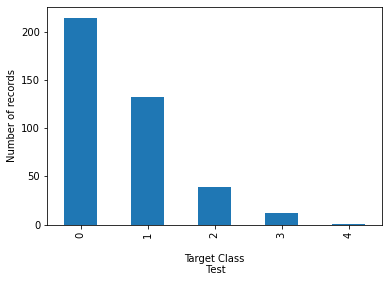



2) Reduced training/test set: 

Input shape reduced train: (600, 2)

Input shape reduced test: (400, 2)



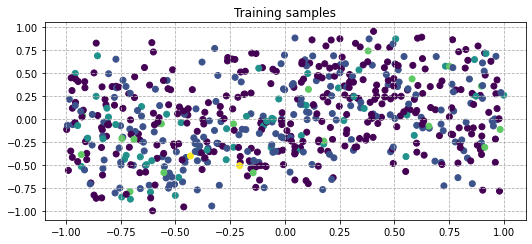

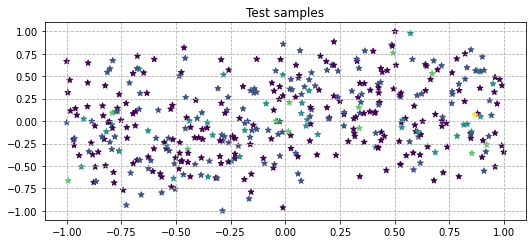

In [9]:
# 1
# Histogman of output
print("\n1) Classification output: \n")
y_test.value_counts().plot.bar()
plt.ylabel('Number of records')
plt.xlabel('\nTarget Class\n Test\n')
plt.show()
print()

# 2
# Reducing the Data-set dimension
print("\n2) Reduced training/test set: \n")
X_train_reduced = X_train.iloc[:,0:2]
X_test_reduced = X_test.iloc[:,0:2]

print("Input shape reduced train: %s" %str(X_train_reduced.shape))
print()


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
# Plot the reduced train set
f1 = plt.figure(1)
plt.scatter(X_train_reduced.iloc[:,0], X_train_reduced.iloc[:,1], c=y_train)
plt.grid(linestyle="--")
plt.title("Training samples")

print("Input shape reduced test: %s" %str(X_test_reduced.shape))
print()

# Plot the reduced test set
f2 = plt.figure(2)
plt.scatter(X_test_reduced.iloc[:,0], X_test_reduced.iloc[:,1], c=y_test, marker="*")
plt.grid(linestyle="--")
plt.title("Test samples")
f2.show(2)

## Tests models on Unbalanced Data-set: 
Implementation of three, progressivly complicated models, for the classification problem:

*   KNN 
*   Decision Tree
*   SVC

#### KNN
The knn is a kind of lower limit for comparing models performance, if a model does worst than knn should be possible to improve it by changing the parameters.

In [85]:
# KNN

# model
knn_model = KNeighborsClassifier()     

print(f"Model: {knn_model} \n")

# grid params
parameters = {  'n_neighbors' : list(range(2,10)), 
                'algorithm': ['kd_tree'],
                'p': list(range(2,5)),
                'metric' : ['minkowski', 'euclidean']
             } 

knn_grid = my_grid_search(knn_model, parameters, num_of_splits=2, verbose=1)

# fit 
print("Model in training... \n")
knn_grid.fit(X_train, y_train)

# best parameters 
print(f"\n{knn_model} best parameters: {knn_grid.best_params_}\n")

# predictions
prediction_test = knn_grid.predict(X_test)
prediction_train = knn_grid.predict(X_train)
print("\nDone\n")

Model: KNeighborsClassifier() 

Grid search execution...

Model in training... 

Fitting 2 folds for each of 48 candidates, totalling 96 fits


KeyboardInterrupt: ignored

###### Performance measure

In [ ]:
# performance over the test samples
print("Test results on the test set:")
classification_metrics(knn_grid, prediction_test, y_test, X, y, num_of_split=2, model_name="KNeighborsClassifier", scoring='f1_macro')

###### KNN: Overfit/Underfit check

In [ ]:
# performance over the train samples
print("Test result on the Train set: \n")
classification_metrics(knn_grid, prediction_train, y_train, X, y, num_of_split=2, model_name="KNeighborsClassifier", verbose=1, scoring='f1_macro')

#### Decision Tree
DTC behave actually worst than knn, even after performing a grid search to find the best parameters.

In [ ]:
# DTC

# model
tree_model = DecisionTreeClassifier()   

print(f"Model: {tree_model} \n")


# grid params
parameters = {
                'max_depth' :[10, 100, 1000, 10000],
                'max_leaf_nodes': list(range(2, 50)), 
                'min_samples_split': [2, 3, 4, 5],
                'max_features': ['sqrt', 'log2', None]
            } 

tree_grid = my_grid_search(tree_model, parameters, num_of_splits=2, verbose=1)

# fit 
print("Model in training... \n")
tree_grid.fit(X_train, y_train)

# best parameters
print(f"\n{tree_model} best parameters: {tree_grid.best_params_}\n")

# predictions
prediction_test = tree_grid.predict(X_test)
prediction_train = tree_grid.predict(X_train)
print("Done\n")

###### Performance measure

In [ ]:
# performance over the test samples
print("Test results on the test set:")
classification_metrics(tree_grid, prediction_test, y_test, X, y, num_of_split=2, model_name="DecisionTreeClassifier", scoring='f1_macro')

###### DTC Overfit/Underfit check

In [ ]:
# performance over the train samples
print("Test result on the Train set: \n")
classification_metrics(tree_grid, prediction_train, y_train, X, y, num_of_split=2, model_name="DecisonTreeClassifier", verbose=1, scoring='f1_macro')

#### SVC

In [ ]:
# SVC

# model
svc_model = SVC()

print(f"Model: {svc_model} \n")

# grid params
parameters = {
                'C':[1,10,100],
                'gamma':[1,0.1,0.001,0.0001], 
                'kernel':['rbf', 'linear']
            }

svc_grid = my_grid_search(svc_model, parameters, num_of_splits=2, verbose=1)

# fit 
print("Model in training... \n")
svc_grid.fit(X_train, y_train)

# best parameters
print(f"{svc_model} best parameters: {svc_grid.best_params_}\n")

# predictions
prediction_test = svc_grid.predict(X_test)
prediction_train = svc_grid.predict(X_train)
print("Done\n")

###### Performance measure

In [ ]:
# performance over the test samples
print("Test results on the test set:")
classification_metrics(svc_grid, prediction_test, y_test, X, y, num_of_split=2, model_name="SupportVectorsClassifier", scoring='f1_macro')

###### SVC: Overfit/Undrfit check

In [ ]:
# performance over the train samples
print("Test result on the Train set: \n")
classification_metrics(svc_grid, prediction_train, y_train, X, y, num_of_split=2, model_name="SupportVectorsClassifier", scoring='f1_macro')

## Balancing Data-set (experimental)
Combination of different strategies to balance the Data-set:
    
*   Naive Oversampling: to generate more data of the minrity classes;

*   Undersampling: to reduce the samples of majority class and try to avoid overfitting;

*   SMOTE: to balancig the dataset with new synthetic data.

Balancing the Data-set... 



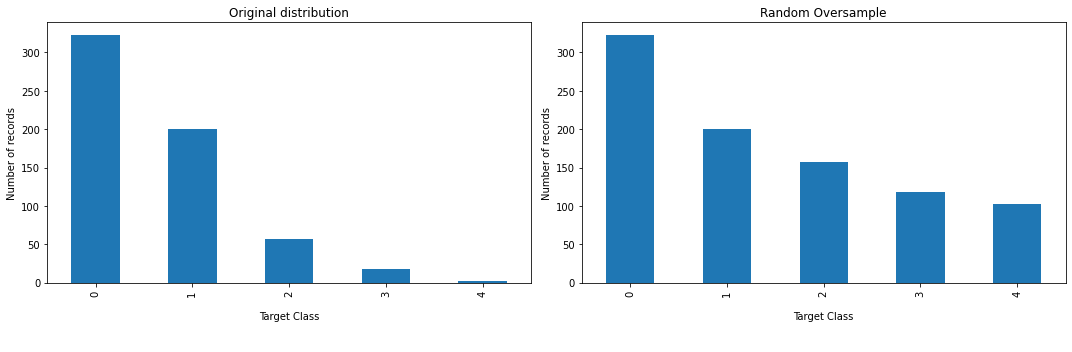

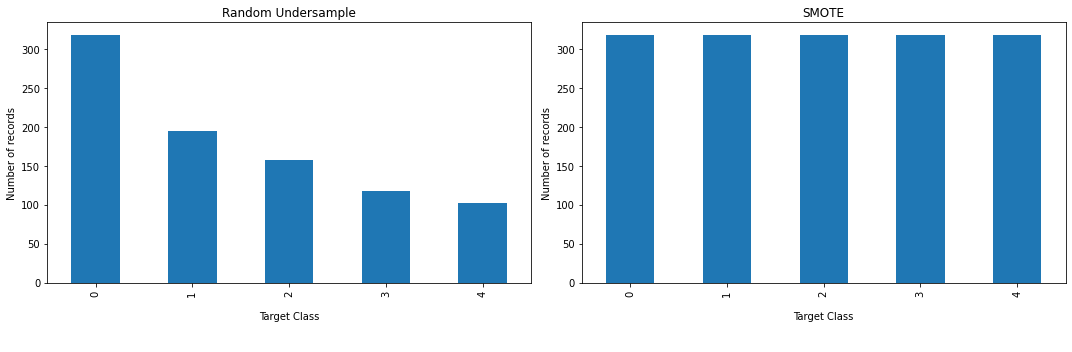

In [22]:
print("Balancing the Data-set... \n")

# Original data
# 1th plot
count = y_train.value_counts()
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
count.plot.bar()
plt.title('Original distribution')
plt.ylabel('Number of records')
plt.xlabel('\nTarget Class\n\n')

# Oversampling
y_samples = dict(count)
oversample = RandomOverSampler(sampling_strategy = {
                                                    0:y_samples[0], 
                                                    1:y_samples[1], 
                                                    2:y_samples[2] + 100, 
                                                    3:y_samples[3] + 100, 
                                                    4:y_samples[4] + 100
                                                    })
Over_X_train, Over_y_train = oversample.fit_resample(X_train, y_train)

# 2th plot
count = Over_y_train.value_counts()
plt.subplot(1, 2, 2)
count.plot.bar()
plt.title('Random Oversample')
plt.ylabel('Number of records')
plt.xlabel('\nTarget Class\n\n')
plt.show()

# Undersampling
y_samples = dict(count)
undersample = RandomUnderSampler(sampling_strategy = {
                                                    0:y_samples[0] - 5, 
                                                    1:y_samples[1] - 5, 
                                                    2:y_samples[2], 
                                                    3:y_samples[3], 
                                                    4:y_samples[4]
                                                    })
Under_X_train, Under_y_train = undersample.fit_resample(Over_X_train, Over_y_train)

# 3th plot
count = Under_y_train.value_counts()
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
count.plot.bar()
plt.title('Random Undersample')
plt.ylabel('Number of records')
plt.xlabel('\nTarget Class\n\n')

# SMOTE
smt = SMOTE(random_state=42, sampling_strategy='all')
Smote_X_train, Smote_y_train = smt.fit_resample(Under_X_train, Under_y_train)

# 4th plot
count = Smote_y_train.value_counts()
plt.subplot(1, 2, 2)
count.plot.bar()
plt.title('SMOTE')
plt.ylabel('Number of records')
plt.xlabel('\nTarget Class\n\n')
plt.show()

## Test models on balanced Data-set

Implementation of SVC over the balanced Data-set.



In [23]:
# SVC
svc_model = SVC()               # redefined to execute the cell alone
print(f"Model: {svc_model} \n")

# grid params
parameters = {
                'C':[1,10,100],
                'gamma':[1,0.1,0.001,0.0001],
                'degree': [1, 2, 3, 4],
                'kernel':['linear', 'poly',]
            }

svc_grid = my_grid_search(svc_model, parameters, num_of_splits=5, verbose=1)

# fit 
print("Model in training... \n")
svc_grid.fit(X_train, y_train)

# best parameters
print(f"\n{svc_model} best parameters: {svc_grid.best_params_}\n")

# predictions
prediction_test = svc_grid.predict(X_test)
prediction_train = svc_grid.predict(X_train)
print("Done\n")

Model: SVC() 

Grid search execution...

Model in training... 

Fitting 5 folds for each of 96 candidates, totalling 480 fits

SVC() best parameters: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}

Done



###### Performance metrics

Test results on the test set:

Classification report for classifier SupportVectorsClassifier:

              precision    recall  f1-score   support

           0       0.57      0.56      0.56       215
           1       0.35      0.35      0.35       133
           2       0.15      0.18      0.16        39
           3       0.25      0.17      0.20        12
           4       1.00      0.00      0.00         1

    accuracy                           0.44       400
   macro avg       0.46      0.25      0.26       400
weighted avg       0.45      0.44      0.44       400


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.4min finished


Scores: [0.44744745 0.43543544 0.46546547 0.44744745 0.48048048]

accuracy 0.455 (+/- 0.03)



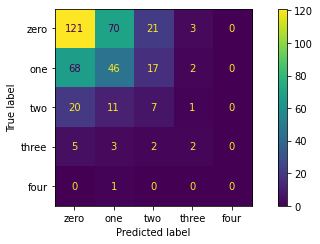

In [24]:
# performance over the test samples
print("Test results on the test set:")
classification_metrics(svc_grid, prediction_test, y_test, X, y, num_of_split=5, model_name="SupportVectorsClassifier", verbose=1)

###### SVC: Overfit/Undrfit check

Test result on the Train set: 


Classification report for classifier SupportVectorsClassifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00         2

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


Fitting 2 folds for each of 36 candidates, totalling 72 fits
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Fitting 2 folds for each of 36 candidates, tota

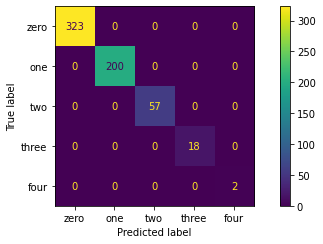

In [ ]:
# performance over the train samples
print("Test result on the Train set: \n")
classification_metrics(svc_grid, prediction_train, y_train, X, y, num_of_split=30, model_name="SupportVectorsClassifier")

#  Regression

---

## Load sample features and regression output.
The Data-set is reloaded, just to be on the safe side. The features are loaded in `X` and the regression output is loaded in `y`. 


In [70]:
print("Data-set: Multi-UAV conflict risk analysis")

# Samples features
X = dataset.iloc[:,:-2]
#print(f'Data-set X:\n {X.describe()}') # uncomment to print the whole features
print(f"\nInput shape: {X.shape}")
print("Number of attributes/features: %d" %(X.shape[1]))
print("Number of samples: %d" %(X.shape[0]))

# Output for regression
y = dataset.iloc[:,-1]
print(f"\nOutput shape: {y.shape}")

Data-set: Multi-UAV conflict risk analysis

Input shape: (1000, 35)
Number of attributes/features: 35
Number of samples: 1000

Output shape: (1000,)


## Normalization and split of the Data-set
Once again... The first job of this cell is to normalize the Data-set, there are various way to do so, here the data are being nomalize between (-1,1). It is possible to test the effect of other methods of normalization just by changing the default parameters, in particular: 

```
normalization_type=0: to normalize between (0,1) 
normalization_type=1: to normalize between (-1,1)
```
In this case also the output `y`, which is a real number, has to be normalized.

The second job is to split the Data-set in training set `X_train`, `y_train` and test set `X_test`, `y_test`, using `test_size` to denote percentage of samples in the test set. The splitting size does influence the finel results.

The Data-set has been normlaized between (-1, 1) with the Min_Max algorithm. 
Train sampels :
                0           1           2           3           4           5   \
count  600.000000  600.000000  600.000000  600.000000  600.000000  600.000000   
mean    -0.016644    0.006931   -0.009356    0.007116   -0.033598   -0.012776   
std      0.565150    0.423788    0.410873    0.644233    0.647434    0.514797   
min     -1.000000   -0.994789   -0.989336   -0.995921   -0.994148   -0.987124   
25%     -0.503357   -0.331853   -0.311980   -0.622080   -0.664991   -0.460935   
50%     -0.011763    0.002704    0.002262    0.009973   -0.069050    0.025672   
75%      0.438351    0.338528    0.311008    0.642789    0.606160    0.419381   
max      1.000000    0.977648    1.000000    1.000000    0.991335    1.000000   

               6           7           8           9   ...          25  \
count  600.000000  600.000000  600.000000  600.000000  ...  600.000000   
mean    -0.004525   -0.0017

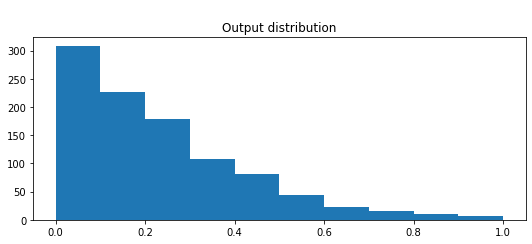

In [71]:
# normalization
X = data_normalization(X, normalization_method='Min_Max', normalization_type=1)
y = data_normalization(y, normalization_method='Min_Max', normalization_type=1, output=True)

# Splitting the Data-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
print(f'Train sampels :\n {X_train.describe()}')
plt.hist(y) 
plt.title("\nOutput distribution") 
plt.show()

## Visualization of a reduced training/test sets (maeby not relevant?)

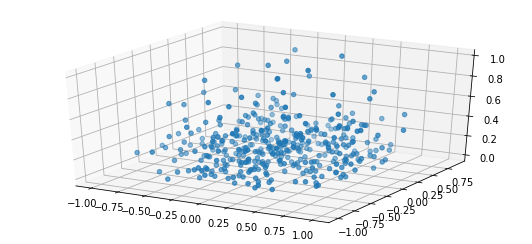

In [54]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline = X_test.iloc[:,1]
yline = X_test.iloc[:,2]
zline = y_test
ax.scatter3D(xline, yline, zline)

## Test models
Implementation of two models for regression:


*   LinearRegression

*   SVR



#### Linear Regression

In [75]:
# LR
lr_model = LinearRegression()
print(f"Model: {lr_model} \n")

# fit 
print("Model in training... \n")
lr_model.fit(X_train, y_train)


# predictions
prediction = lr_model.predict(X_test)
print("Done\n")

# performance over the test samples
print("Test results on the test set:")
regression_metrics(lr_model, X_test, y_test, prediction)

Model: LinearRegression() 

Model in training... 

Done

Test results on the test set:
Mean squared error: 0.04
Regression R2score: -0.021
Regression model score: -0.021


#### SVR

In [47]:
# SVR
#svr_model = SVR(kernel='rbf', C=1, degree=1, gamma='scale')
svr_model = SVR()
print(f"Model: {svr_model} \n")
    
# grid params
parameters = {'kernel':['rbf', 'poly'], 'C':[1, 0.1, 0.01], 'degree':[1, 2, 3, 4, 5]}

svr_grid = my_grid_search(svr_model, parameters, num_of_splits=3, verbose=1, scoring='r2') 

# fit 
print("Model in training... \n")
svr_grid.fit(X_train, y_train)

# best parameters
print(f"\n{svr_model} best parameters: {svc_grid.best_params_}\n")

# predictions
prediction = svr_grid.predict(X_test)
print("Done\n")

# performance over the test samples
print("Test results on the test set:")
regression_metrics(svr_grid, X_test, y_test, prediction)

Model: SVR() 

Grid search execution...

Model in training... 

Fitting 3 folds for each of 30 candidates, totalling 90 fits

SVR() best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Done

Test results on the test set:
Mean squared error: 0.04
Regression R2score: 0.063
Regression model score: 0.063


## Plot approssimation function 

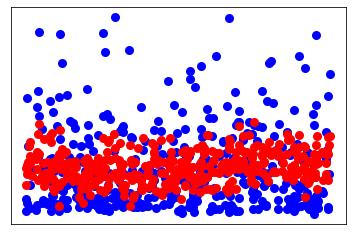

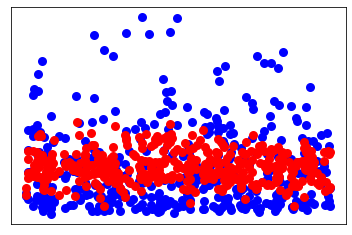

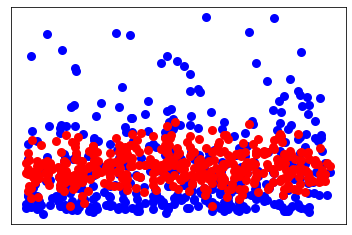

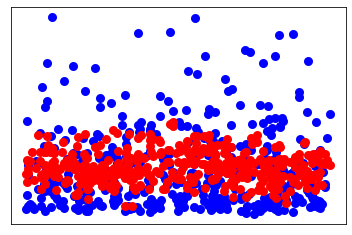

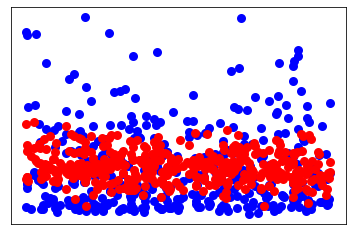

In [ ]:
#for c in range(0,35,7): #uncomment this line and comment the following to generate just 5 plots
for c in range(0,35):                            
    # loop over the feature columns c to generate 35 plots 
    # of  (X_test_c_r y_test) and  (X_test_c_r y_predict) points
    # to check for overlaps

    plt.scatter(X_test.iloc[:,c], y_test, color='blue', linewidth=3)
    plt.scatter(X_test.iloc[:,c], prediction, color='red', linewidth=3)
    plt.xticks(())
    plt.yticks(())
    plt.show()
